In [1]:
import pandas as pd
from copy import deepcopy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import numpy as np
import matplotlib.pyplot as plt
import warnings


warnings.filterwarnings('ignore')

In [2]:
# init df
df = pd.read_csv('titanic.csv', sep=";")

In [3]:
# preprocess data
cols = list(df.columns)
a, b = cols.index('Survived'), cols.index('Embarked')
cols[b], cols[a] = cols[a], cols[b]
df = df[cols]

df.drop(["Embarked", "PassengerId", "Cabin", "Ticket", "Name"], axis=1, inplace=True)

df = df.replace({'Sex': {'female': 0, 'male': 1}})

df = df.drop(df[(df.Sex == 'unknown') | (df.Age == 'NaN')].index)

df = df.dropna()

df = df.reset_index(drop=True)

cols = list(df.columns)
a, b = cols.index('Pclass'), cols.index('Age')
cols[b], cols[a] = cols[a], cols[b]
df = df[cols]

cols = list(df.columns)
a, b = cols.index('Fare'), cols.index('Sex')
cols[b], cols[a] = cols[a], cols[b]
df = df[cols]


train_df, test_df = train_test_split(df, test_size=0.3)

x_train, y_train = train_df.to_numpy()[:,:-1], train_df.to_numpy()[:,-1]
x_test, y_test = test_df.to_numpy()[:,:-1], test_df.to_numpy()[:,-1]


std_scaler = StandardScaler().fit(x_train[:, :2])
minmax_scaler = MinMaxScaler().fit(x_train[:, 2:])

def preprocessor(X):
    A = deepcopy(X)
    A[:, :2] = std_scaler.transform(X[:, :2])
    A[:, 2:] = minmax_scaler.transform(X[:, 2:])
    return A

preprocessor_transformer = FunctionTransformer(preprocessor)

p1 = Pipeline([('Scaler', preprocessor_transformer),
              ('Logistic Regression', LogisticRegression())])

y_train=y_train.astype('int')

In [4]:
# training model
p1.fit(x_train, y_train)
train_pred_prob = p1.predict_proba(x_train)[:, 1]
test_pred_prob = p1.predict_proba(x_test)[:, 1]
train_pred = p1.predict(x_train)
test_pred = p1.predict(x_test)

In [5]:
# preparing to ROC
final_prob_target_and_class = np.column_stack([test_pred_prob.T, test_pred.T, y_test.T]).astype(float)


final_prob_target_and_class = final_prob_target_and_class[np.argsort(final_prob_target_and_class[:, 0])][::-1]

match = np.zeros((final_prob_target_and_class.shape[0],))

for i in range(final_prob_target_and_class.shape[0]):
    match[i] = final_prob_target_and_class[i, 2]

n = match.sum().astype(int)
m = (match.shape[0]-n).astype(int)

coord_y = np.linspace(0, 1, num = n+1)
coord_x = np.linspace(0, 1, num = m+1)
coords = np.zeros((n+m+1, 2))

h_i = w_i = 0
coords[0] = coord_x[0], coord_y[0]
for i in range(1, n+m):
    if match[i-1] == 1:
        h_i += 1
    else:
        w_i += 1
    coords[i] = coord_x[w_i], coord_y[h_i]

coords[-1] = 1, 1

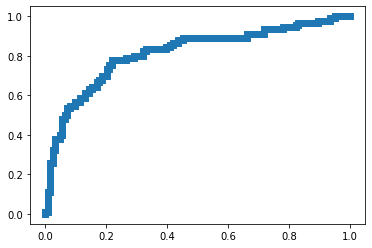

In [6]:
# ROC
plt.scatter(coords[:, 0], coords[:, 1], marker = ",")

In [7]:
# fit polynomial w/ high degree
deg = 100
z = np.polyfit(coords[:, 0], coords[:, 1], deg)

In [8]:
x = np.array(coords[:, 0])
y = np.zeros((len(coords[:, 0],))) 

for i in range(len(x)):
    for j in range(deg+1):
        y[i] += (z[j] * (x[i] ** (deg - j)))  

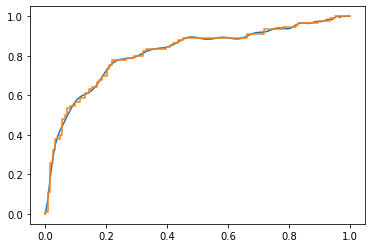

In [9]:
y = y.clip(min=0, max=1)
plt.plot(x, y)
plt.plot(coords[:, 0], coords[:, 1])

In [10]:
# calculate the integral
aucroc = 0
for i in range(deg+1):
    aucroc += z[i]/(deg-i+1)

In [11]:
# compare w/ sklearn gini
gini_doge = 2 * aucroc - 1
gini_sklearn = 2 * roc_auc_score(final_prob_target_and_class[:, 2], final_prob_target_and_class[:, 0]) - 1 
print(f"gini_doge = {gini_doge}\ngini_sklearn = {gini_sklearn}\nabs = {abs(gini_sklearn-gini_doge)}")

gini_doge = 0.6360163815665474
gini_sklearn = 0.6311827956989249
abs = 0.004833585867622503
